# Task 2: CNN for telling the time
---
*Author: Lukas Welzel for Group 24 (?)*

### Index:
- [Imports](#imports)
- [Main Content](#main-content) (xN)
  - [Overview](#overview)
  - [Loading Data](#loading-data)
  - [Selecting Model](#selecting-model)
  - [Experiments](#experiments)
- [Citations](#citations)
- [Footer](#footer)

In [15]:
# imports
# use environment_TTT.yaml an related IDL kernel
from TTTcnn import *
# making sure everything looks as it should
print("TF version: ", tf.__version__)
print(f"Available devices:")
[print("\t", t) for t in tf.config.list_physical_devices('GPU')]; # at least one GPU

TF version:  2.6.0
Available devices:
	 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
	 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


## Main Content
### Overview
In TTTcnn.py we defined a CNN by sublassing Keras' Model class. This "TellTheTimeCNN" class will be the main focus of this task. The main changes from the base Model is the setup that is now encapsulated and can be interacted with using the "settings" argument. TTTcnn.py also contains some utility functions for data loading.

### Loading Data

In [3]:
x_train, base_y_train, x_test, base_y_test = get_data()

Training data on /job:localhost/replica:0/task:0/device:GPU:0


### Selecting Model
Instances of TellTheTimeCNN have a full set of default settings, namely:

---
<blockquote>
    <p>"learning_rate":       1e-2 </p>
    <p>"epochs":              50 </p>
    <p>"batch_size":          128 </p>
    <p>"encoding":            "decimal" </p>
    <p>"type":                ["regression"],  # classification, regression (can be sequence) </p>
    <p>"actfn_normalization": ["tanh"],  # must be sequence if type is sequence </p>
    <p>"loss":                ["mse_sincos"]  # must be sequence if type is sequence </p>
</blockquote>

---

As is obvious from the last few lines the model is set up to support multiple heads.

In [4]:
# setting up a default model without a rng seed
default_model = TellTheTimeCNN()

Model: "tell_the_time_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 1)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 146, 146, 64)      584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)  

In [7]:
# the default model uses decimal encoding which we will now use
# encoding of data can be done via the encode_y function of any TellTheTimeCNN instance.
y_train, y_test = default_model.encode_y(base_y_train), default_model.encode_y(base_y_test)
try:
    print("Encoding from hh,mm -> f: ", base_y_train.shape, " -> ", y_train.shape)
except AttributeError:
    print("Encoding from hh,mm -> f: ", base_y_train.shape, " -> ", len(y_train))

Encoding from hh,mm -> f:  (14400, 2)  ->  (14400,)


In [ ]:
default_model.train(x_train, y_train)
default_model.test(x_test, y_test)

### Experiments

Since we had large issues with training stability for both classification and regression we implement an early stopping method and learning rate schedule to improe stability and not waste training time on "lost" runs where the losses explode. We found that, optimizer making use of momentum where needed for timely convergence, however we note that simple gradient descent optimizers might have improved the stability of the training. In practice however, the architecures that were tried did not find good optima with simple optimizers and failed to converge no matter the learning rate. To further improve staiblity we attempted to implement a learning rate scheduler in combination with a function to reduce the learning rate when the validation loss plateaus. Sadly, TF2.6.0 still contains a 2 year old bug that makes this combination impossible, see e.g. https://github.com/tensorflow/tensorflow/issues/41639.

In [8]:
import matplotlib
import matplotlib.pyplot as plt

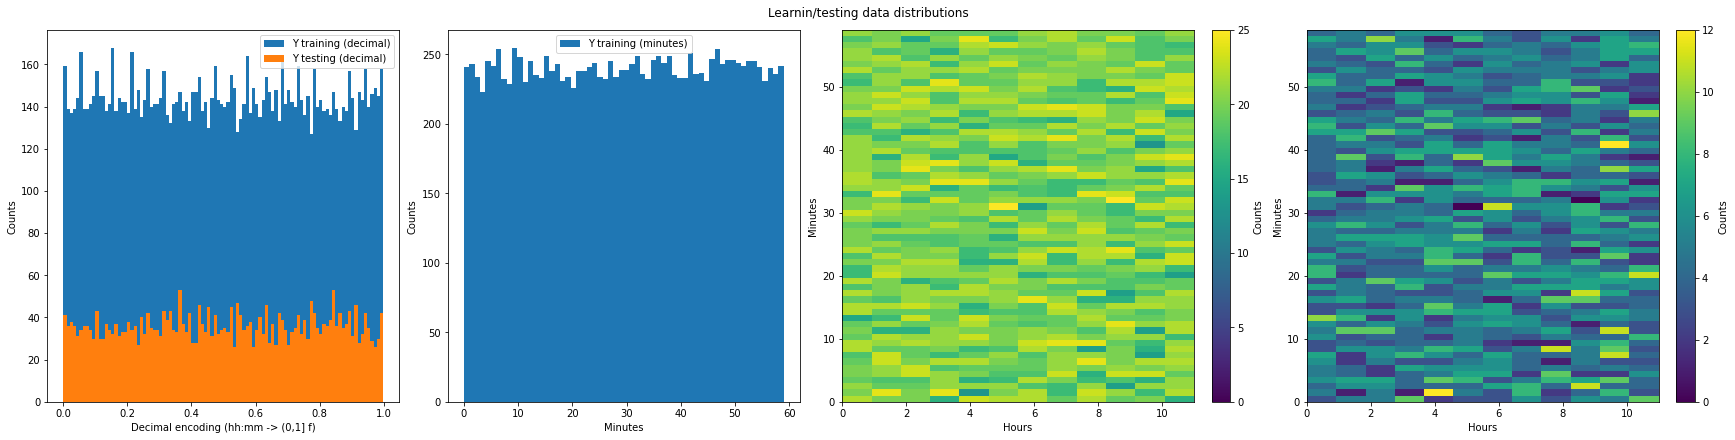

In [13]:
# Data visualization
fig, (ax, ax4, ax2, ax3) = plt.subplots(1, 4, constrained_layout=True, figsize=(24, 6))
ax.hist(y_train, bins=100, label="Y training (decimal)")
ax.hist(y_test, bins=100, label="Y testing (decimal)")
ax.set_xlabel("Decimal encoding (hh:mm -> (0,1] f)")
ax.set_ylabel("Counts")
ax.legend()

hist = ax2.hist2d(base_y_train[:, 0], base_y_train[:, 1], vmin=0., bins=[12, 60], label="Y training (hh:mm)")
fig.colorbar(hist[3], ax=ax2,label="Counts")
ax2.set_xlabel("Hours")
ax2.set_ylabel("Minutes")

hist = ax3.hist2d(base_y_test[:, 0], base_y_test[:, 1], vmin=0., bins=[12, 60], label="Y testing (hh:mm)")
fig.colorbar(hist[3], ax=ax3, label="Counts")
ax3.set_xlabel("Hours")
ax3.set_ylabel("Minutes")

ax4.hist(base_y_train[:, 1], bins=60, label="Y training (minutes)")
ax4.set_xlabel("Minutes")
ax4.set_ylabel("Counts")
ax4.legend()

fig.suptitle("Learnin/testing data distributions")

plt.show()

In [ ]:
# Classification
def prep_class_1head(settings, n_classes):
    class_head1_model = TellTheTimeCNN(settings=settings)
    y_train = default_model.encode_y(base_y_train, n_classes=n_classes)
    y_test = default_model.encode_y(base_y_test, n_classes=n_classes)
    return class_head1_model, y_train, y_test

default_classification_settings = {
    "learning_rate": 1.0e-3,
    "encoding": "common_classes",
    "type": ["classification"],  # classification, regression (can be sequence)
    "loss": ["categorical"],  # must be sequence if type is sequence
    "n_classes": [72],  # must be sequence if type is sequence
}

In [ ]:
# SINGLE HEAD CLASSIFICATION MODELS
# settings 72 classes, single head
settings = {**default_classification_settings, **{"n_classes": [72]}}
class72_head1_model, y_train, y_test = prep_class_1head(settings, n_classes)

# settings 24 classes, single head
settings = {**default_classification_settings, **{"n_classes": [24]}}
class24_head1_model, y_train, y_test = prep_class_1head(settings, n_classes)

# settings 12 classes, single head
settings = {**default_classification_settings, **{"n_classes": [12]}}
class12_head1_model, y_train, y_test = prep_class_1head(settings, n_classes)

# settings 720 classes, single head, you really should not test this
settings = {**default_classification_settings, **{"n_classes": [720]}}
class720_head1_model, y_train, y_test = prep_class_1head(settings, n_classes)

In [ ]:
# Regression


In [ ]:
# Multihead
# Hour and Minute classification heads (bad idea but better than the 720 classes)
# Hour classification and Minute regression heads (makes sense right?)
# Hour and Minute regression heads (makes even more sense since the hour angle changes as the minute angle changes as well)
